# Human bone marrow of healthy human donors - Preprocessing

In this notebook, we pre-process cyTOF data of bone marrow samples from 8 healthy donors. Data were provided by Oetjen et al (JCl Insight, 2018). 
We employ the following steps:
1. Load and convert fcs file into anndata format
2. Arcsinh-normalisation with pre-determined cofactor
3. Compute knn-graph
4. Compute Leiden clustering

In the next notebook, we focus on the annotation of the clusters and compare with the original annotation provided by the authors.

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
import pytometry as pm


sc.logging.print_versions()
sc.settings.verbosity = 3

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         8.4.0
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.7
cloudpickle                 2.0.0
cycler      

Add date.

In [2]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [3]:
# Define a nice colour map for gene expression
colors2 = pl.cm.Reds(np.linspace(0, 1, 80))
colors3 = pl.cm.Greys_r(np.linspace(0.7, 0.8, 35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list("my_colormap", colorsComb)

In [4]:
import os

In [5]:
data_path = "./../data/Oetjen_2018/"

## Read data

In [6]:
files_all = os.listdir(data_path + "cytof_data/")

In [7]:
files = [fileID for fileID in files_all if fileID.endswith(".fcs")]

In [8]:
files

['20171103_T_01_1.fcs',
 '20171103_U_01_1.fcs',
 '20171103_B_01_1.fcs',
 '20171103_A_01_1.fcs',
 '20171103_H_01_1.fcs',
 '20171103_C_01_1.fcs',
 '20171103_O_01_1.fcs',
 '20171103_J_01_1.fcs']

In [9]:
adatas = []
for fileID in files:
    meta_info = fileID.split(".fcs")[0].split("_")

    adata = pm.io.read_fcs(data_path + "cytof_data/" + fileID)
    adata.obs["sample"] = meta_info[1]

    # move Time etc to .obs
    pm.pp.split_signal(adata, var_key="channel", option="element", data_type="cytof")

    adatas.append(adata)

In [10]:
adatas[0].var_names

Index(['89Y-CD45', '103Rh', '120Sn-Environ', '127I', '131Xe-Environ',
       '133Cs-Environ', '138Ba-Environ', '140Ce-EQ4-beads', '141Pr-CD49D',
       '142Nd-CD11a', '143Nd-CD5', '144Nd-CD195', '145Nd-CD4', '146Nd-CD8a',
       '147Sm-CD7', '148Nd-CD16', '149Sm-CD25', '150Nd-CD134---OX40',
       '151Eu-CD2', '152Sm-CD95---FAS', '153Eu-CD366---TIM3', '154Sm',
       '155Gd-CD279---PD1', '156Gd-CD183', '158Gd-CD194', '159Tb-CD197',
       '160Gd-CD28', '161Dy-CD152---CTLA4', '162Dy-CD69', '163Dy',
       '164Dy-CD161', '165Ho-CD45RO', '166Er-CD44', '167Er-CD27',
       '168Er-CD278---ICOS', '169Tm-CD45RA', '170Er-CD3', '171Yb-CD9',
       '172Yb-CD57', '173Yb-CD137---41BB', '174Yb-HLA-DR',
       '175Lu-CD223---LAG3', '176Yb-CD127', '190BCKG', '191Ir-DNA1',
       '193Ir-DNA2', '195Pt-VIABILITY', '208Pb-Environ', '209Bi'],
      dtype='object')

Concatenate all data.

In [11]:
adata_all = ann.AnnData.concatenate(*adatas, join="outer", uns_merge="unique")

Remove unused channels. According to Supplementary Table S5 of the Oetjen et al. publication, less channels were used than reported in the file. In addition, we add the corresponding antibody marker for each element.  

In [12]:
marker_list = adata_all.var["marker"].values

In [13]:
rename_dict = {}

for marker in marker_list:
    elem_info = marker.split("-")
    rename_dict[marker] = elem_info[-1] if len(elem_info) > 1 else "unused"
    if elem_info[-1] == "DR":  # fix HLR-DR
        rename_dict[marker] = "-".join(elem_info[-2:])

In [14]:
adata_all.var["AB"] = pd.Categorical(adata_all.var["marker"]).map(rename_dict)

Remove the unused channels, *i.e.* the ones with no marker or the ones termed 'Environ' or 'EQ4beads'. 

In [15]:
marker_keep = [
    marker
    for marker in adata_all.var["AB"]
    if marker not in ["unused", "Environ", "beads"]
]

In [16]:
adata_all = adata_all[:, np.in1d(adata_all.var["AB"], marker_keep)]

In [17]:
adata_all

View of AnnData object with n_obs × n_vars = 4938816 × 37
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta'

Save to file.

In [18]:
adata_all.write(data_path + "anndata/" + "cytof_data_concatenated.h5ad")

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


## Preprocess data

In [19]:
adata_all = sc.read(data_path + "anndata/" + "cytof_data_concatenated.h5ad")

In [20]:
adata_all

AnnData object with n_obs × n_vars = 4938816 × 37
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta'

Check sample size.

In [21]:
adata_all.obs["sample"].value_counts()

B    956776
O    934338
H    848865
J    599766
T    517921
A    500671
C    381121
U    199358
Name: sample, dtype: int64

### Normalise data

We use a normalization cofactor of 5.

In [23]:
cofactor = 5

Save original data as layer.

In [24]:
adata_all.layers["original"] = adata_all.X

Normalize.

In [25]:
pm.tl.normalize_arcsinh(adata=adata_all, cofactor=cofactor)

AnnData object with n_obs × n_vars = 4938816 × 37
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta'
    layers: 'original'

### Filter for viability and DNA staining

The data comes with three markers for DNA content and viability staining. Let us investigate the data quality based on these markers and filter out potentially dead cells.

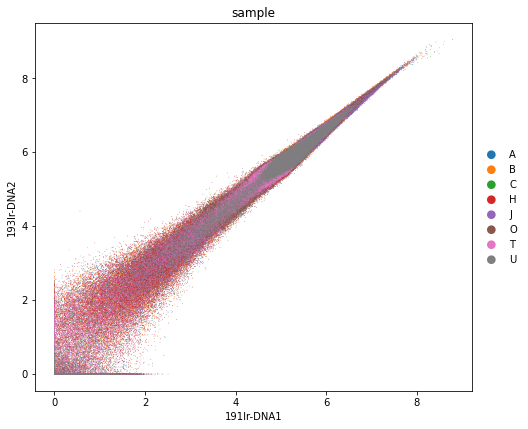

In [55]:
rcParams["figure.figsize"] = (7, 7)
sc.pl.scatter(adata_all, x="191Ir-DNA1", y="193Ir-DNA2", color="sample", size=2)

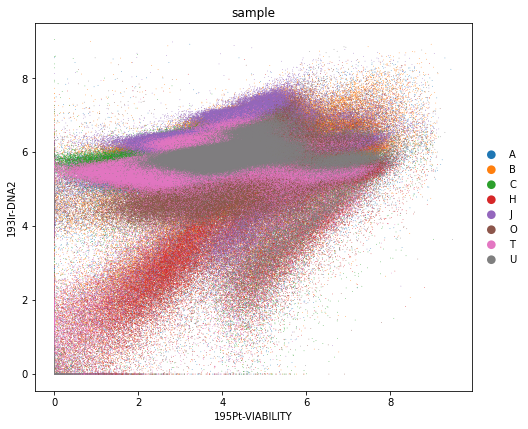

In [56]:
rcParams["figure.figsize"] = (7, 7)
sc.pl.scatter(adata_all, x="195Pt-VIABILITY", y="193Ir-DNA2", color="sample", size=2)

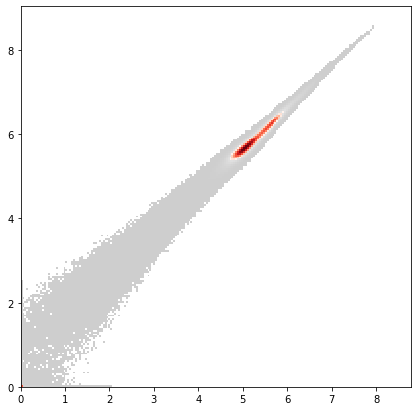

In [57]:
x = adata_all.var["AB"] == "DNA1"
y = adata_all.var["AB"] == "DNA2"

ax = pl.hist2d(
    adata_all.X[:, x].flatten(),
    adata_all.X[:, y].flatten(),
    bins=200,
    cmin=5,
    cmap=mymap,
)
pl.show()

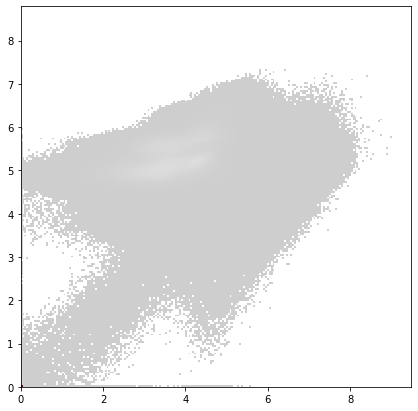

In [58]:
x = adata_all.var["AB"] == "VIABILITY"
y = adata_all.var["AB"] == "DNA1"

ax = pl.hist2d(
    adata_all.X[:, x].flatten(),
    adata_all.X[:, y].flatten(),
    bins=200,
    cmin=5,
    cmap=mymap,
)
pl.show()

Overall, we consider all events with less than 2 in either 'DNA1', 'DNA2' or less than 1 in 'VIABILITY' as poor quality events and filter them out.

In [59]:
dna1_low = adata_all.X[:, adata_all.var["AB"] == "DNA1"].flatten() < 2
dna2_low = adata_all.X[:, adata_all.var["AB"] == "DNA2"].flatten() < 2
viab_low = adata_all.X[:, adata_all.var["AB"] == "VIABILITY"].flatten() < 1

viability_filter = (dna1_low + dna2_low + viab_low) == 0

In [60]:
np.sum(viability_filter)

4829382

In [61]:
adata_all = adata_all[viability_filter]

Remove 'DNA1', 'DNA2' and 'VIABILITY' from data matrix.

In [62]:
viab_marker = ["DNA1", "DNA2", "VIABILITY"]

for marker in viab_marker:
    adata_all.obs[marker] = adata_all.X[:, adata_all.var["AB"] == marker]

adata_all = adata_all[:, np.invert(np.in1d(adata_all.var["AB"], viab_marker))].copy()

Trying to set attribute `.obs` of view, copying.


In [63]:
adata_all

AnnData object with n_obs × n_vars = 4829382 × 34
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch', 'DNA1', 'DNA2', 'VIABILITY'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta', 'sample_colors'
    layers: 'compensated'

Save normalised and filtered data to file.

In [64]:
adata_all.write(data_path + "anndata/" + "cytof_data_norm.h5ad")

### Visualise data as UMAP

In [6]:
adata_all = sc.read(data_path + "anndata/" + "cytof_data_norm.h5ad")

In the next step, we compute a knn-graph, an embedding and a clustering of the data.

In [65]:
sc.pp.pca(adata_all)

computing PCA
    with n_comps=33
    finished (0:00:13)


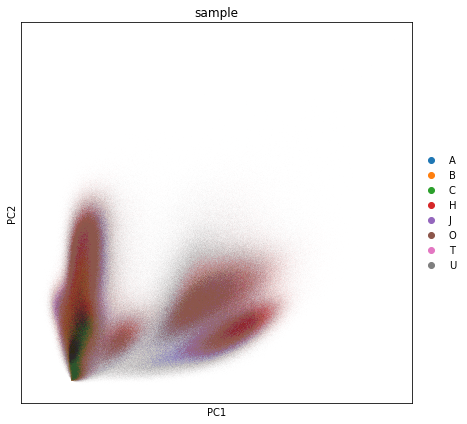

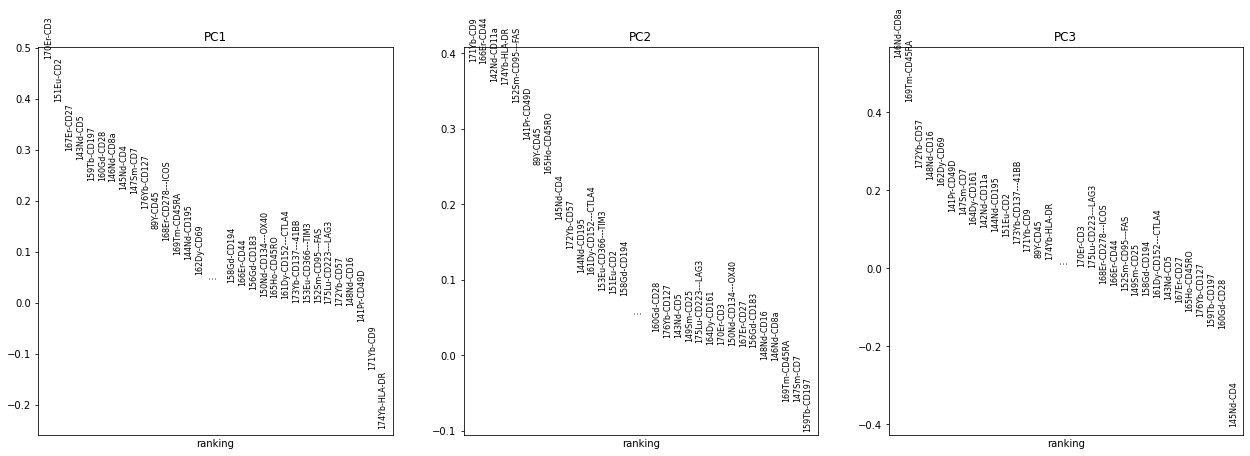

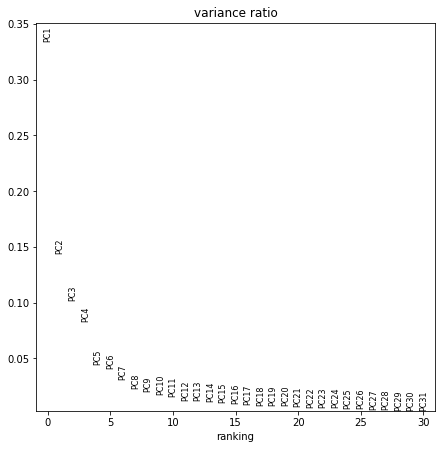

In [66]:
sc.pl.pca_overview(adata_all, color="sample")

In [67]:
sc.pp.pca(adata_all, n_comps=10)
sc.pp.neighbors(adata_all, n_neighbors=15, use_rep="X_pca")

computing PCA
    with n_comps=10
    finished (0:00:10)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:18:48)


In [74]:
adata_all

AnnData object with n_obs × n_vars = 4829382 × 34
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch', 'DNA1', 'DNA2', 'VIABILITY'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta', 'sample_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'compensated'
    obsp: 'distances', 'connectivities'

In [69]:
adata_all.write(data_path + "anndata/" + "cytof_data_norm.h5ad")

In [6]:
adata_all = sc.read(data_path + "anndata/" + "cytof_data_norm.h5ad")

In [73]:
adata_all

AnnData object with n_obs × n_vars = 4829382 × 34
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch', 'DNA1', 'DNA2', 'VIABILITY'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta', 'sample_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'compensated'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.tl.umap(adata_all)

computing UMAP


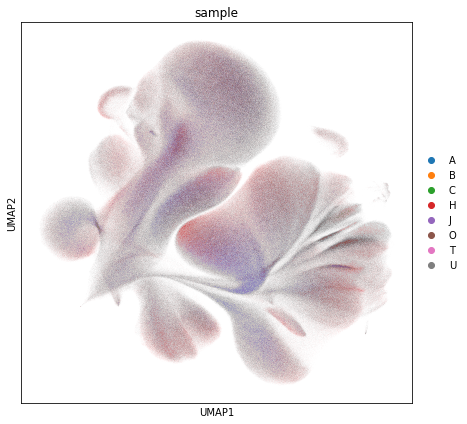

In [75]:
sc.pl.umap(adata_all, color="sample")

### Save to file

In [76]:
adata_all.write(data_path + "anndata/" + "cytof_data_norm.h5ad")

End of the pre-processing notebook.